In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['OMP_NUM_THREADS'] = "1"

# file ops
from pathlib import Path
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings(action="ignore", category=RuntimeWarning)

# spatial
import xarray as xa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rioxarray

# machine learning
from dask.distributed import get_client, Client, LocalCluster, SSHCluster
from concurrent.futures import ThreadPoolExecutor
import xgboost as xgb

# custom
from coralshift.utils import file_ops, config, utils
from coralshift.dataloading import get_data
from coralshift.plotting import spatial_plots, visualise_results
from coralshift.machine_learning import static_models, run_model, ml_results
from coralshift.processing import ml_processing
from coralshift.processing import spatial_data

# import cmipper
from cmipper import utils as cmipper_utils
from cmipper import file_ops as cmipper_file_ops

# data fps
gt_data_dir = config.gt_data_dir
config_fp = "/maps/rt582/coralshift/runs/config_files/config_test.yaml"
config_info = file_ops.read_yaml(config_fp)

/maps/rt582/miniforge3/envs/shiftpy/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# minimise complexity of example data
config_info["env_vars"] = ["tos"]
config_info["datasets"] = ["cmip6", "unep"]
config_info["depth_mask"] = [-1000, 1000]
config_info["resolution"] = 0.1
# get example merged
ds = ml_processing.ProcessMLData(config_info).get_merged_datasets()[["tos_overall_mean", "UNEP_GDCR", "elevation"]]

Searching for correct CMIP files in: /maps-priv/maps/rt582/coralshift/data/env_vars/cmip6/EC-Earth3P-HR/r1i1p2f1/regridded
	calculating statistics for static ML model(s)...


calculating statistics for variables: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


	applying spatial buffering...
40 raster(s) to spatially buffer...


Buffering variables: 100%|██████████| 40/40 [00:02<00:00, 15.83it/s]


	resampling dataset to 0.1 degree(s) resolution...

Resampling pipeline: written raster CRS to EPSG:4326
Loading UNEP_GDCR xarray at 0.004 degrees resolution.
	applying spatial buffering...
1 raster(s) to spatially buffer...


Buffering variables: 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]


	resampling dataset to 0.1 degree(s) resolution...

Resampling pipeline: written raster CRS to EPSG:4326
Loading gebco elevation xarray across [-31, -1] latitudes & [139, 167] longitudes from /maps-priv/maps/rt582/coralshift/data/bathymetry/gebco/GEBCO_2023_n90-0_s90-0_w180-0_e180-0.nc.
	applying spatial buffering...
1 raster(s) to spatially buffer...


Buffering variables: 100%|██████████| 1/1 [00:00<00:00, 10.48it/s]

Transposing filled array to match the original shape.


	resampling dataset to 0.1 degree(s) resolution...

Resampling pipeline: written raster CRS to EPSG:4326


In [2]:
    # print("Best parameters found: ", search_object.best_params_)
    # print("Lowest RMSE found: ", np.sqrt(np.abs(search_object.best_score_)))

    # # Save the trained model
    # joblib.dump(search_object, '/maps/rt582/coralshift/notebooks/wip/trained_model.joblib')

import joblib
# load joblib search_object
search_object = joblib.load('/maps/rt582/coralshift/notebooks/wip/trained_model.joblib')

In [8]:
# get rmse from search_object (eval_metric)
search_object.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.29999999999999993, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=31, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=945, n_jobs=128,
             num_parallel_tree=None, random_state=None, ...)

In [9]:
search_object.best_score_

0.8419385319989381

In [ ]:
# calculate r2 from rmse
r2 = 1 - search_object.best_score_

In [6]:
# search_object.best_params_
search_object.best_score_
search_object.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.29999999999999993, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=31, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=945, n_jobs=128,
             num_parallel_tree=None, random_state=None, ...)

# Full-fold XGBoost

Most ported from local version

In [ ]:
def extract_best_from_df(df: pd.DataFrame) -> pd.DataFrame:
    
    best_df = pd.Series()
    for col in list(df.columns):
        # get lowest mean and associated standard deviation
        if "mean" in col:
            mean_val = df[col].min()
            best_df[col] = mean_val
            index_val = df.loc[df[col] == mean_val].index
            std_col = str(col).replace("mean", "std")
            # index first since returns as a numpy array, but only single value (or should be)
            std_val = df[std_col].iloc[index_val].values[0] 
            best_df[std_col] = std_val

    return best_df


def cv_subset(var_list: list[str], num_boost_round: int = 1000, nfold: int = 7, early_stopping_rounds: int = 20, params: dict = None) -> pd.DataFrame:
    dtrain = xgb.DMatrix(X_train[var_list], y_train)
    dtest = xgb.DMatrix(X_test[var_list], y_test)

    if not params:
        # hyperparameters
        params = {"objective": "reg:squarederror", "tree_method": "hist"}
    evals = [(dtrain, "train"), (dtest, "validation")]
    # cross-fold validation
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        nfold=nfold,
        early_stopping_rounds=early_stopping_rounds
    )
    return cv_results

def score_subsets(dict_of_var_lists: dict[list[str]], prev_results_df: dict = None, cv_subset_kwargs: dict = None):
    # TODO: while running, ~333 tasks shown by htop, with some small number running (<num_CPUs). What are these
    prev_runs = []
    if prev_results_df is not None:
        prev_runs = list(prev_results_df.columns)

    results_dict = {}
    for name, var_list in tqdm(dict_of_var_lists.items(), desc="Running cross-fold validation for variable subsets"):
        # skip previous variable investigations. TODO: name may not correspond with correct variables if changed
        if name not in prev_runs:
            print(f"searching with '{name}' variable subset...")
            # if not already a list, cast to list (e.g. for natural specification of individual variable values)
            if not isinstance(var_list, list):
                var_list = [var_list]
            if cv_subset_kwargs:    # TODO: one-liner version of this
                result = cv_subset(var_list, **cv_subset_kwargs)
            else:
                result = cv_subset(var_list)
            # assign best results to specific dictionary entry. TODO: won't always be the min
            results_dict[name] = extract_best_from_df(result)
        else:
            print(f"'{name}' cv skipped due to existing results for this variable name.")
            results_dict[name] = prev_results_df[name]

    return pd.DataFrame.from_dict(results_dict)


# cv_subset(["tos_january_mean"])
dict_of_var_lists = {
    "january_tos": "tos_january_mean",
    "tos": [col for col in X.columns if "tos" in col],
    "significant_tos": ["tos_january_mean", "tos_january_min", "tos_january_max", "tos_june_mean", "tos_june_min", "tos_june_max", "tos_overall_mean"],
    "all_vars": [col for col in X.columns],
    "wfo": [col for col in X.columns if "wfo" in col],
    "thetao": [col for col in X.columns if "thetao" in col],
    "elevation": "elevation",
    "slope_elevation": ["elevation", "slope"],
    "slope": "slope"
}

# results_df=pd.DataFrame()     # wipes previous
results_df = score_subsets(dict_of_var_lists, prev_results_df=results_df, cv_subset_kwargs={"num_boost_round": 10000})

# XGBoost hyperparameter tuning

In [ ]:
import xgboost as xgb
# $ conda install -c conda-forge py-xgboost-gpu
from sklearn.model_selection import train_test_split

X_train = pd.read_parquet("/maps/rt582/coralshift/data/ml_ready/-20_10/0-01/train_X_0-01_S30-0_S2-0_E140-0_E166-0.parquet")
y_train = pd.read_parquet("/maps/rt582/coralshift/data/ml_ready/-20_10/0-01/train_y_0-01_S30-0_S2-0_E140-0_E166-0.parquet")
X_test = pd.read_parquet("/maps/rt582/coralshift/data/ml_ready/-20_10/0-01/test_X_0-01_S30-0_S2-0_E140-0_E166-0.parquet")
y_test = pd.read_parquet("/maps/rt582/coralshift/data/ml_ready/-20_10/0-01/test_y_0-01_S30-0_S2-0_E140-0_E166-0.parquet")

X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)
# TODO: rename y column

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [ ]:
# open joblib model object
import joblib
model_fp = "/maps/rt582/coralshift/notebooks/wip/trained_model.joblib"
model = joblib.load(model_fp)

In [ ]:
model

In [ ]:
import joblib
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

rs_params = static_models.xgb_search_grid(n_trials=5)

# data = xgb.DMatrix(data=X, label=y)
xgb_reg = xgb.XGBRegressor(n_jobs=128, seed=42)
grid_mse = RandomizedSearchCV(
    estimator=xgb_reg, param_distributions=rs_params, scoring="r2", cv=3, verbose=10, n_jobs=1, n_iter=100)
grid_mse.fit(X, y)

print("Best parameters found: ", grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

# Save the trained model
joblib.dump(grid_mse, 'trained_model.joblib')

In [ ]:
print("Best parameters found: ", grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))
# save 

# Custom cross-fold validation
- Try with XGBoost
- Try with diffferent train-test split: Has no discernable effect
- Try with 'first' rather than mean: Has no discernable effect
- Try with higher resolution: will only be possible with XGBoost due to speed, probably
- GBR-30 bathymetry

In [ ]:
combined_df = pd.concat(predictions).to_frame()
combined_df = combined_df.loc[~combined_df.index.duplicated(keep='last')]

In [ ]:
# combine list of pd.Series on index, taking first of any overlapping values
test = pd.concat(predictions).groupby(level=0).first()

import cartopy.crs as ccrs
f, ax = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={"projection": ccrs.PlateCarree()}, dpi=300)
spatial_plots.plot_spatial(spatial_data.spatially_reform_data(combined_df)[0], fax=(f, ax[0]), title="Predictions", cbar_dict={"orientation": "horizontal"})
# spatial_plots.plot_spatial(ds["UNEP_GDCR"], fax=(f, ax[1]))
# mask xarray dataset where elevation is between -2000 and 10
depth_masked_gt = ds["UNEP_GDCR"].where((ds["elevation"] >= -2000) & (ds["elevation"] <= 10))
# normalise array (0-1)
depth_masked_gt = (depth_masked_gt - depth_masked_gt.min()) / (depth_masked_gt.max() - depth_masked_gt.min())
spatial_plots.plot_spatial(depth_masked_gt, fax=(f, ax[1]), title="Ground truth", cbar_dict={"orientation": "horizontal"})

In [ ]:
# TODO: issue with inconsistent lengths once nans are removed. Not sure what's causing it. 5 nan difference.
# join dataframes on index
merged = pd.concat(
    [pd.Series(depth_masked_gt.to_dataframe()["UNEP_GDCR"], name="label"), pd.Series(combined_df[0], name="predictions")],
    axis=1,
)

# depth_masked_gt.to_dataframe()["UNEP_GDCR"]
plt.scatter(merged["label"], merged["predictions"], alpha=0.3, c="#d83c04")
plt.plot(
    [0, 1],
    [0, 1],
    color="gray",
    alpha=0.5,
    linestyle=(5, (10, 3)),
    # label=f"Inference R$^2$ = {overfit_r2:.2f}",
    )
plt.xlabel("Ground truth")
plt.ylabel("Predictions")
# square plot
plt.xlim(0, 1)
plt.ylim(0, 1)

In [ ]:
config_info = file_ops.read_yaml(config_fp)
config_info["resolution"] = 0.01
num_splits = 20
predictions = []
model_code = "rf_reg"
n_jobs = 128
# get merged datasets
ds = ml_processing.ProcessMLData(config_info=config_info).get_merged_datasets()

random_state = 0
total_num_samples = 1
combined_preds = []
# split datasets with incrementing random seed
# for split_i in range(num_splits):
while len(combined_preds) < total_num_samples:
    # split data
    config_info["random_state"] = random_state
    (trains, tests, vals), ds_info = ml_processing.ProcessMLData(config_info=config_info).generate_ml_ready_data(ds = ds)
    total_num_samples = len(trains[1]) + len(tests[1])
    # initialise model
    model = static_models.ModelInitialiser(model_type=model_code, n_jobs=n_jobs).get_model()
    # fit model on train set
    model.fit(trains[0], trains[1])
    
    # infer on test set
    preds = pd.Series(model.predict(tests[0]), tests[1].index)
    # append inferred (series) to list
    predictions.append(preds)
    combined_preds = pd.concat(predictions, axis=1).mean(axis=1)
    
    print(f"Ratio complete: {len(combined_preds)}/{total_num_samples}")
    random_state += 1

In [ ]:
import cartopy.crs as ccrs
f, ax = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={"projection": ccrs.PlateCarree()}, dpi=300)
spatial_plots.plot_spatial(spatial_data.spatially_reform_data(combined_preds)[0], fax=(f, ax[0]), title="Predictions", cbar_dict={"orientation": "horizontal"})
# spatial_plots.plot_spatial(ds["UNEP_GDCR"], fax=(f, ax[1]))
# mask xarray dataset where elevation is between -2000 and 10
depth_masked_gt = ds["UNEP_GDCR"].where((ds["elevation"] >= -2000) & (ds["elevation"] <= 10))
# normalise array (0-1)
depth_masked_gt = (depth_masked_gt - depth_masked_gt.min()) / (depth_masked_gt.max() - depth_masked_gt.min())
spatial_plots.plot_spatial(depth_masked_gt, fax=(f, ax[1]), title="Ground truth", cbar_dict={"orientation": "horizontal"})

In [ ]:
import cartopy.crs as ccrs
f, ax = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={"projection": ccrs.PlateCarree()}, dpi=300)
spatial_plots.plot_spatial(spatial_data.spatially_reform_data(combined_preds)[0].sel(latitude=slice(-15,-10), longitude=slice(140,145)), fax=(f, ax[0]), title="Predictions", cbar_dict={"orientation": "horizontal"})
# spatial_plots.plot_spatial(ds["UNEP_GDCR"], fax=(f, ax[1]))
# mask xarray dataset where elevation is between -2000 and 10
depth_masked_gt = ds["UNEP_GDCR"].where((ds["elevation"] >= -2000) & (ds["elevation"] <= 10))
# normalise array (0-1)
depth_masked_gt = (depth_masked_gt - depth_masked_gt.min()) / (depth_masked_gt.max() - depth_masked_gt.min())
spatial_plots.plot_spatial(depth_masked_gt.sel(latitude=slice(-15,-10), longitude=slice(140,145)), fax=(f, ax[1]), title="Ground truth", cbar_dict={"orientation": "horizontal"})

In [ ]:
# TODO: issue with inconsistent lengths once nans are removed. Not sure what's causing it. 5 nan difference.
# join dataframes on index
merged = pd.concat(
    [pd.Series(depth_masked_gt.to_dataframe()["UNEP_GDCR"], name="label"), pd.Series(combined_preds, name="predictions")],
    axis=1,
)

# depth_masked_gt.to_dataframe()["UNEP_GDCR"]
plt.scatter(merged["label"], merged["predictions"], alpha=0.3, c="#d83c04")
plt.plot(
    [0, 1],
    [0, 1],
    color="gray",
    alpha=0.5,
    linestyle=(5, (10, 3)),
    # label=f"Inference R$^2$ = {overfit_r2:.2f}",
    )
plt.xlabel("Ground truth")
plt.ylabel("Predictions")
# square plot
plt.xlim(0, 1)
plt.ylim(0, 1)

### Just tos and bathymetry at 0.1º
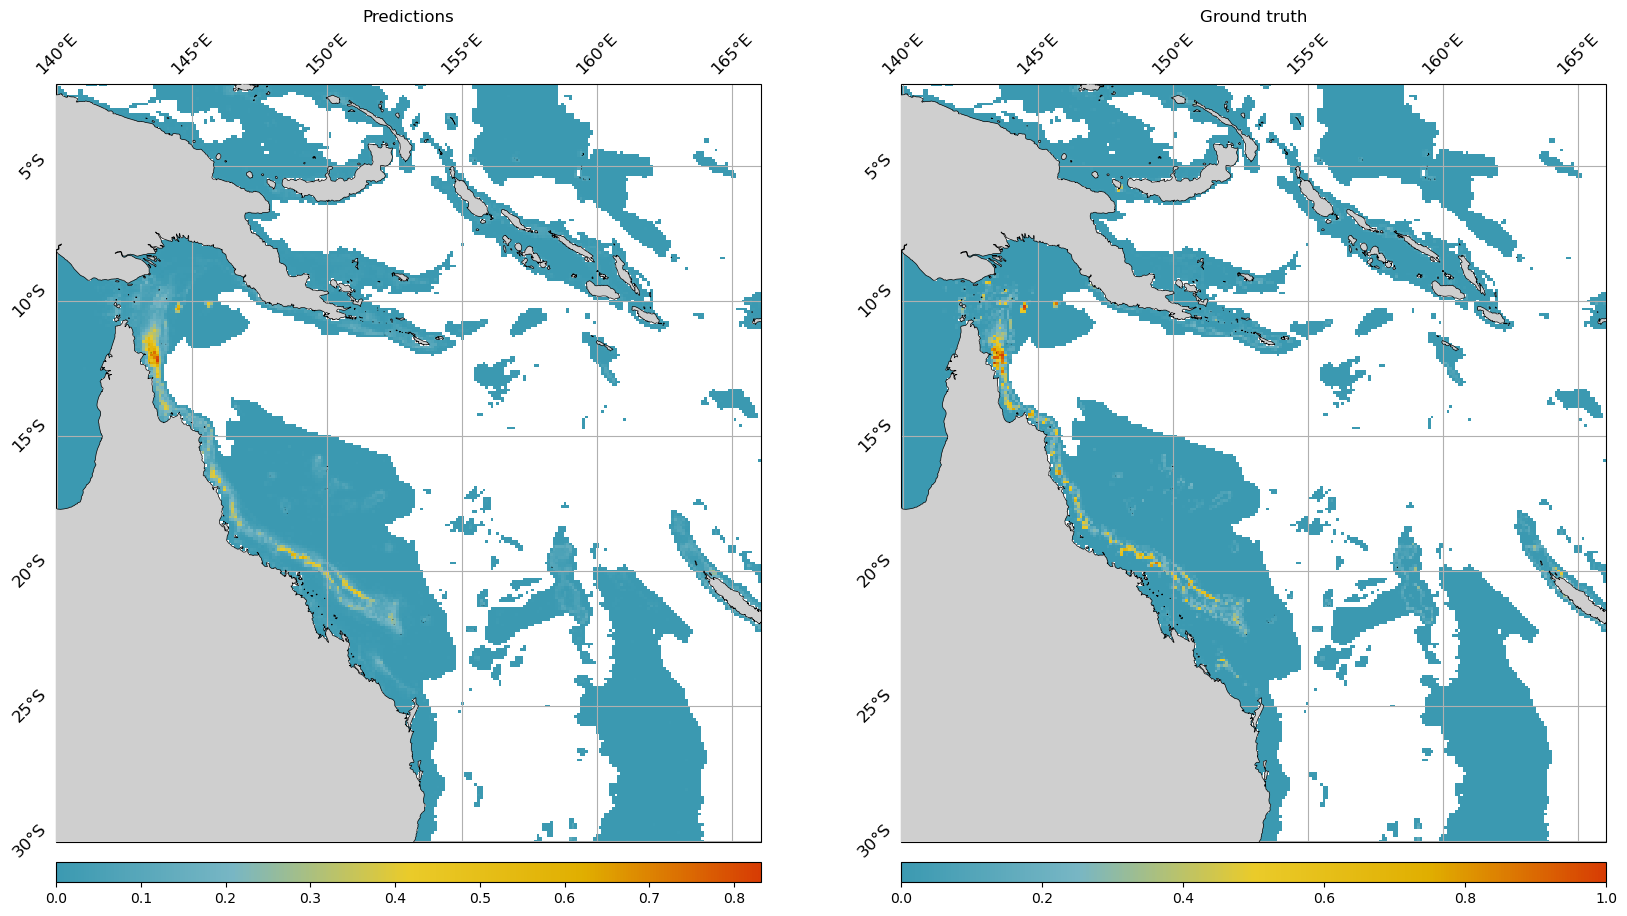
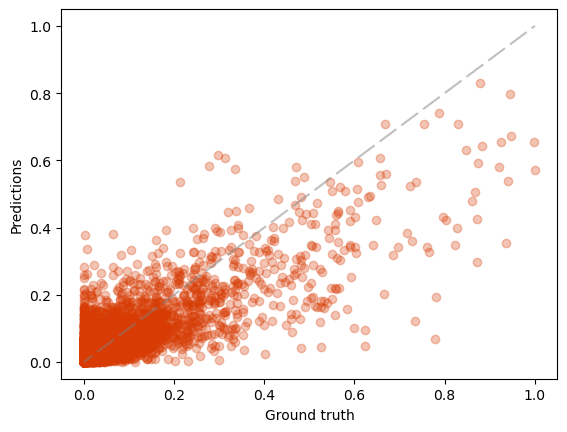

### All vars at 0.1º
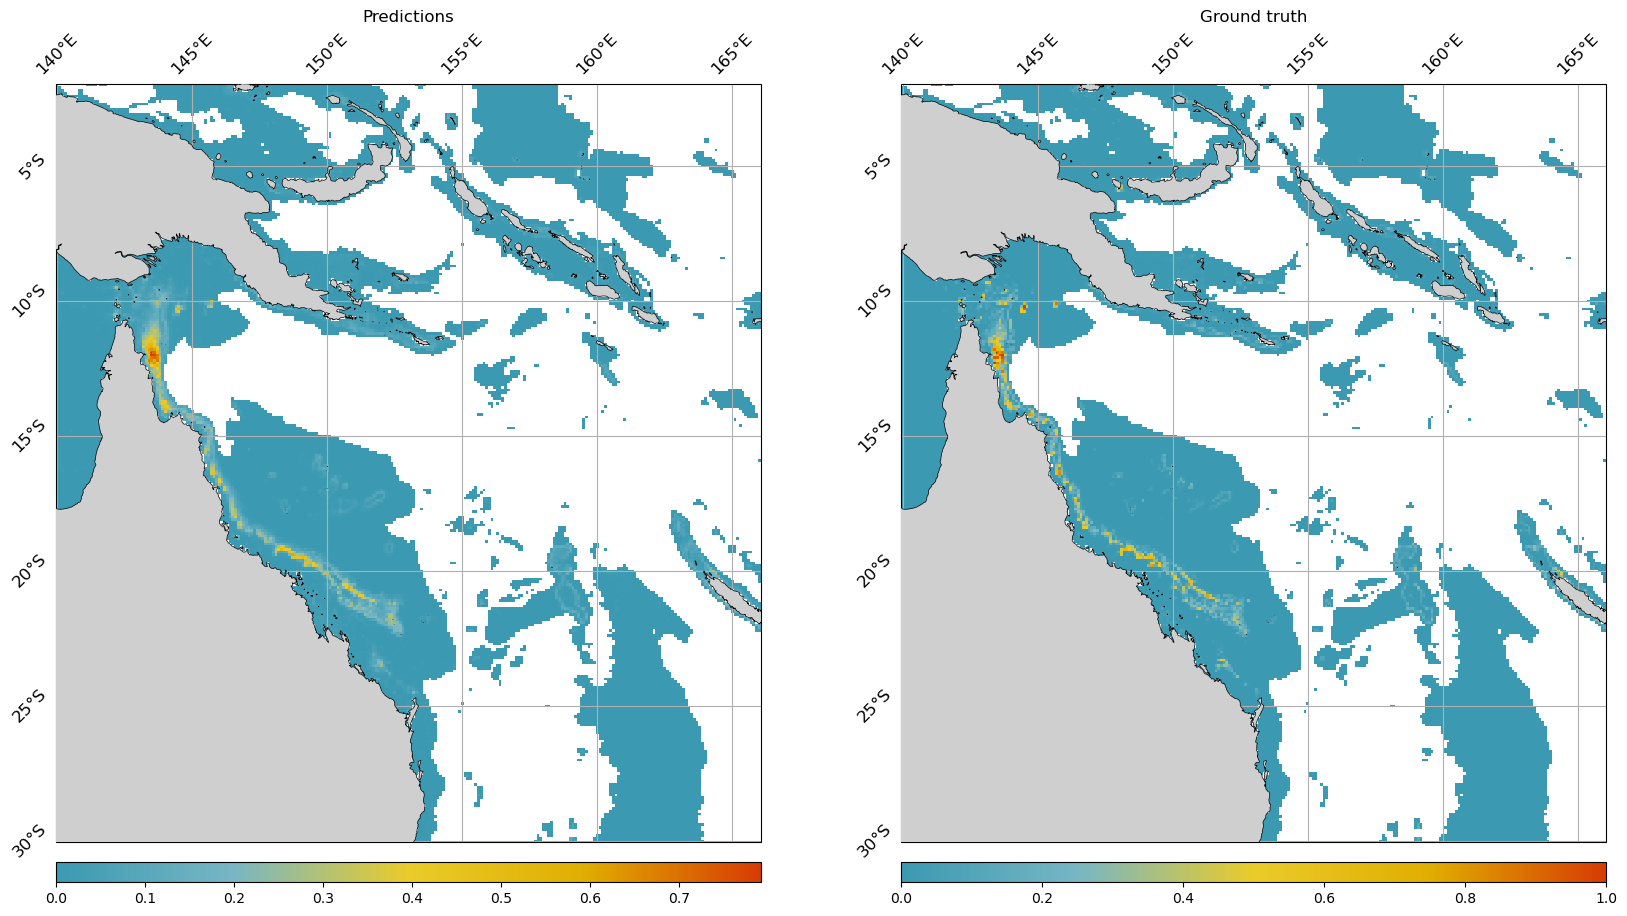
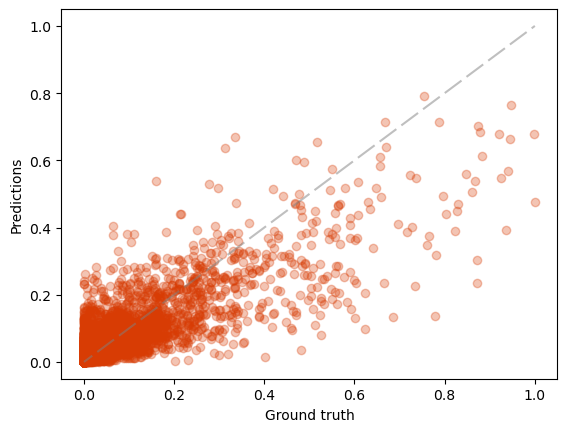

### Only bathymetry at 0.1º (phew)
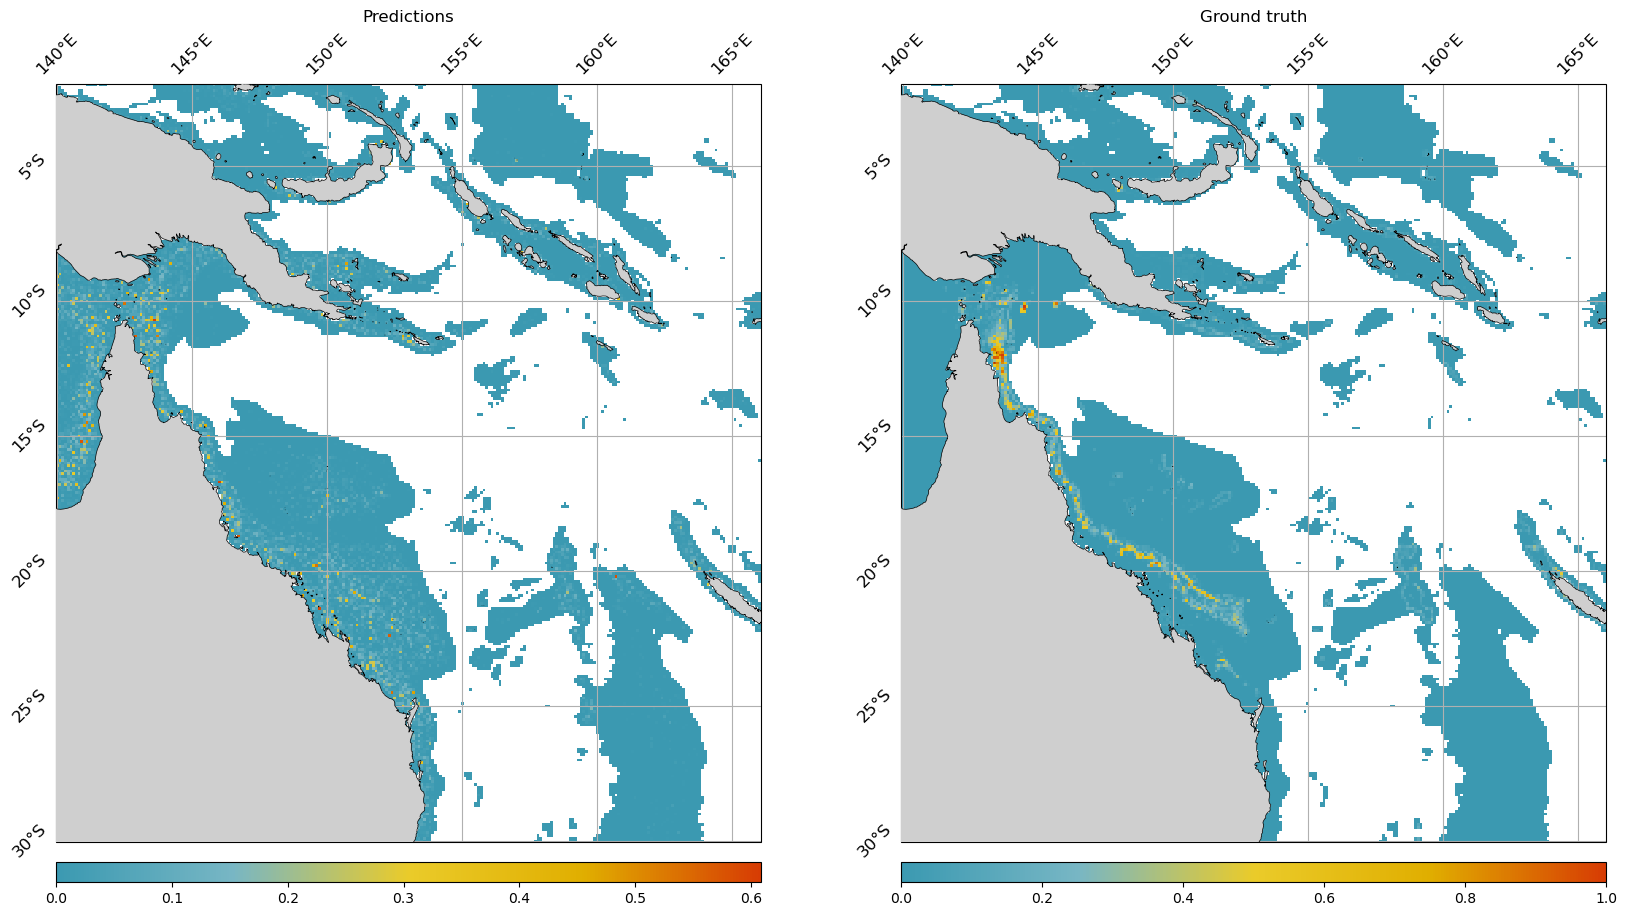
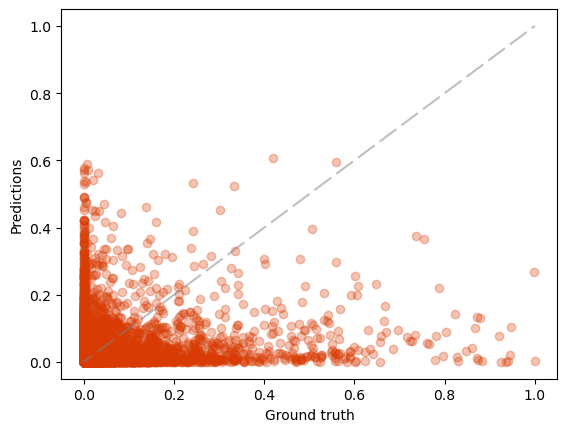

### Only wfo and bathymetry at 0.1º
Implies that it's just a statistical learning exercise rather than actuallly learning a meaningful relationship

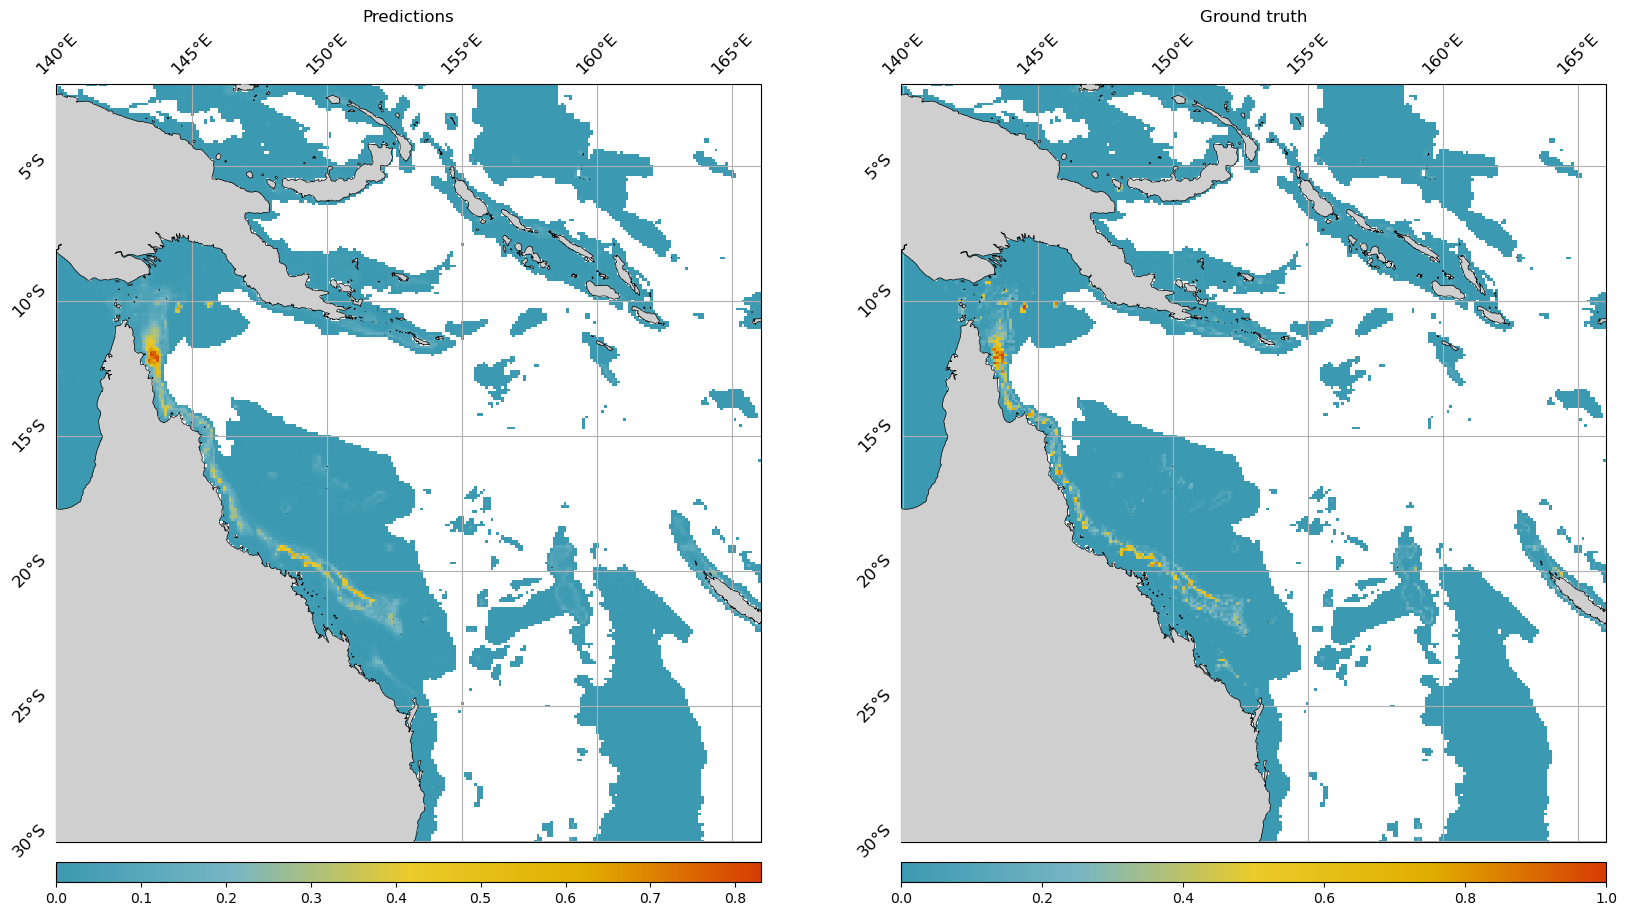
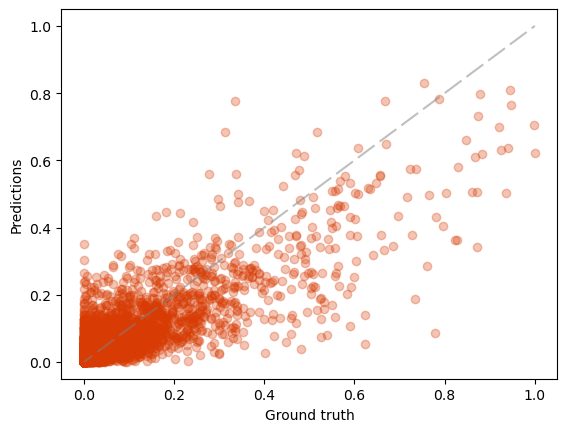

### Only wfo (no bathymetry) at 0.1º
It really is just a statistical trick: but why does it only work for environmental variables rather than bathymetry?

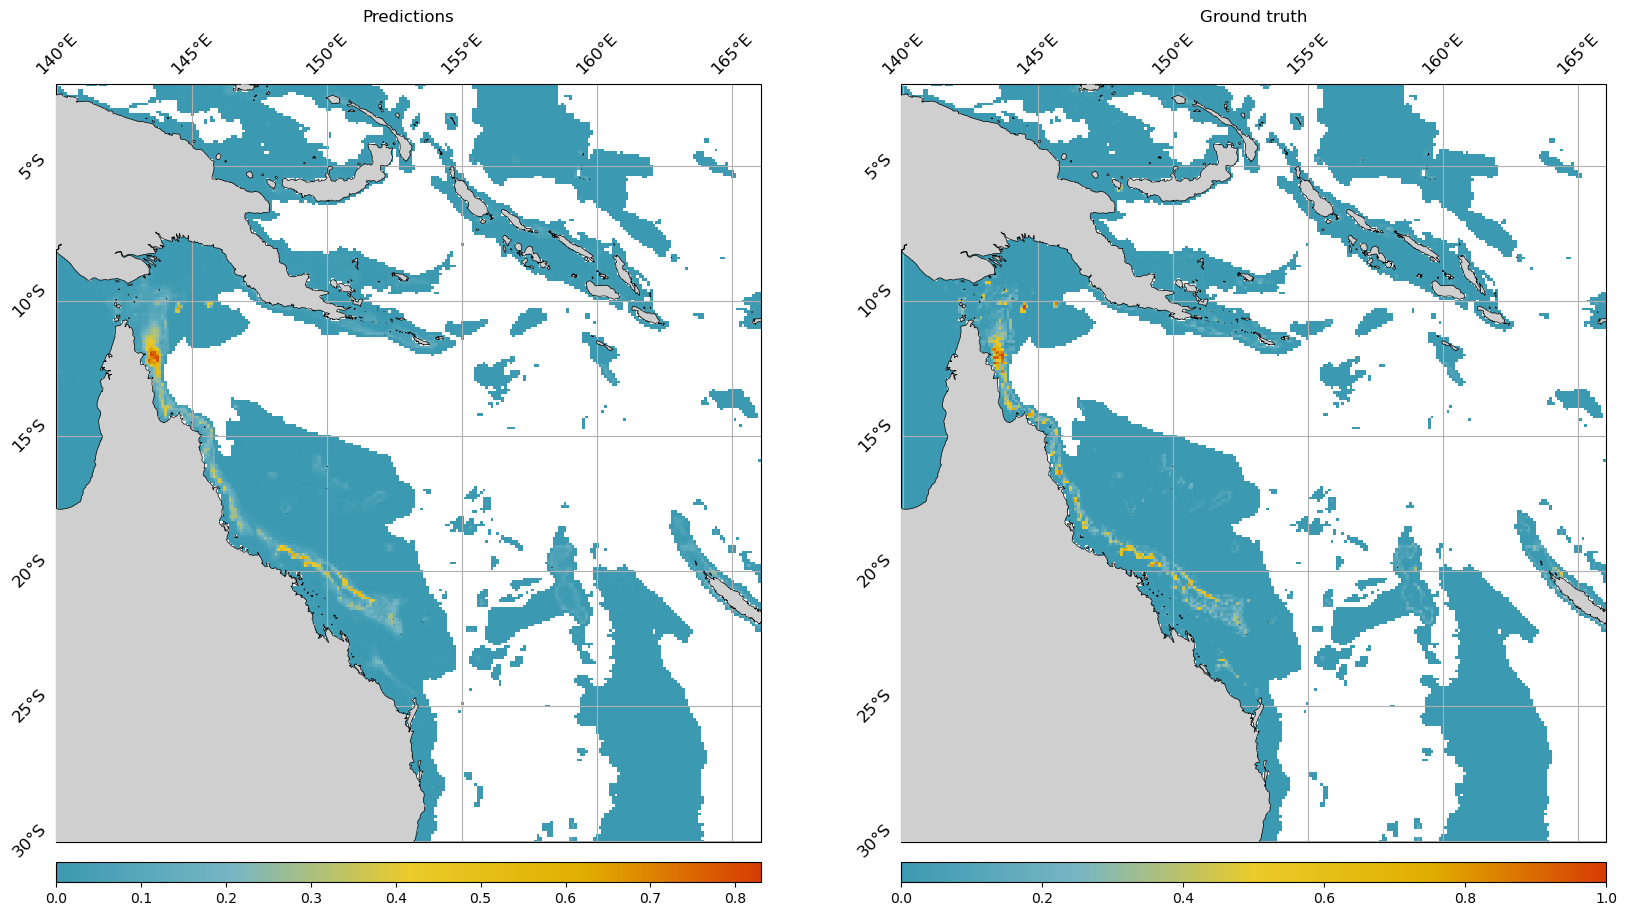
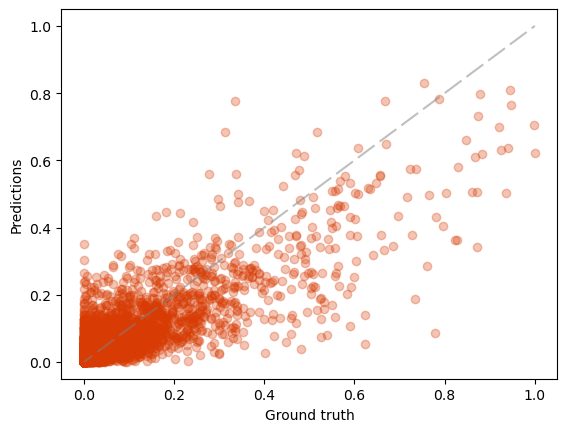

### All variables, 0.5/0.5 train/test split
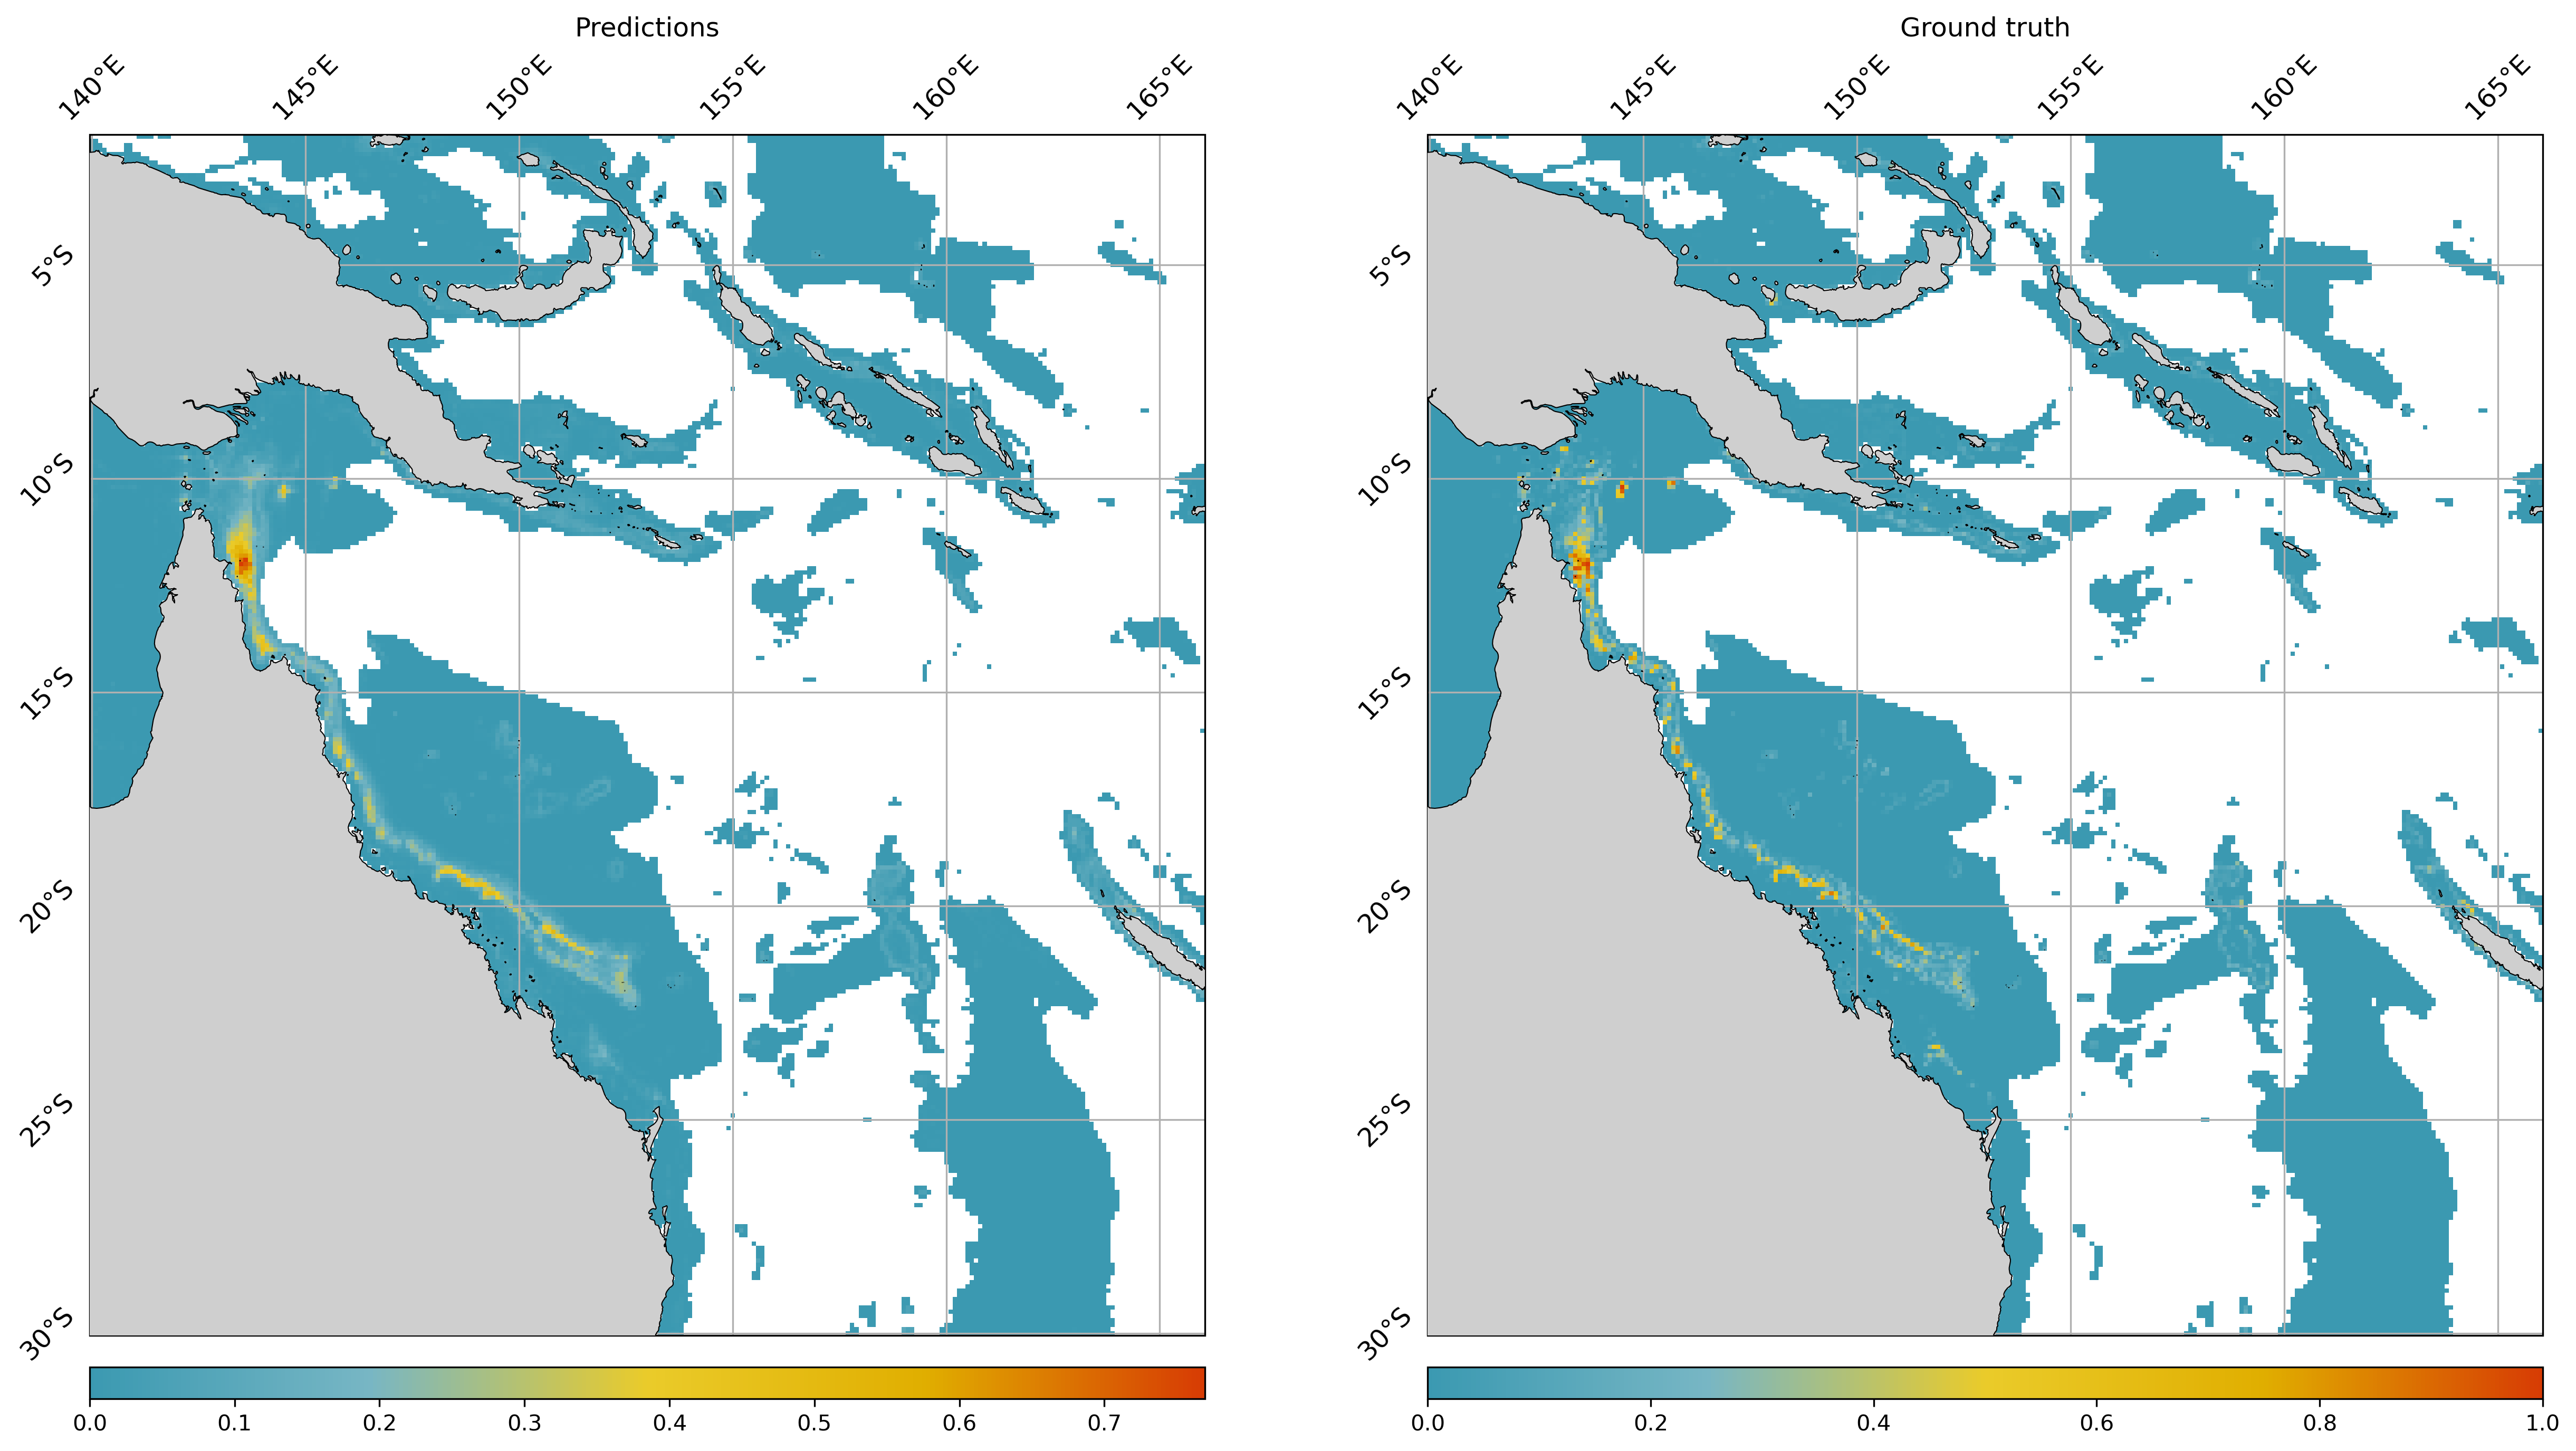
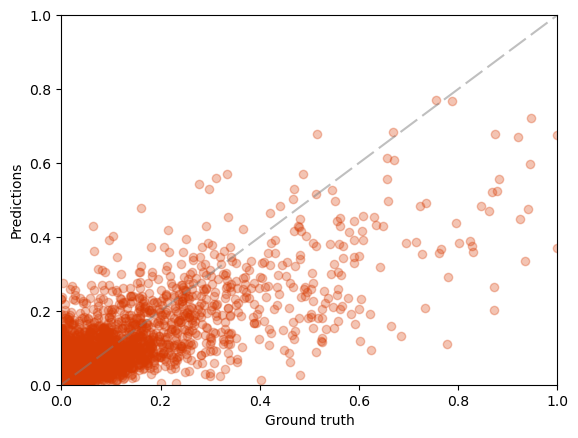

In [ ]:
visualise_results.plot_regression_histograms(merged["label"].dropna()[:len(merged["predictions"].dropna())], merged["predictions"].dropna())

In [ ]:
# send to dataframe and remove nans
depth_masked_gt.to_dataframe()["UNEP_GDCR"].dropna()

In [ ]:
plt.scatter(depth_masked_gt.to_dataframe()["UNEP_GDCR"].dropna()[:len(combined_preds)], combined_preds)

In [ ]:
config_info = file_ops.read_yaml(config_fp)
data = ml_processing.ProcessMLData(config_info=config_info).generate_ml_ready_data()

In [ ]:
spatial_data.spatially_reform_data(data[0][0][0]["tos_january_mean"], 0.1)

In [ ]:
1/6

In [ ]:
spatial_plots.plot_spatial(spatial_data.spatially_reform_data(data[0][0][0]["tos_january_mean"], 0.1)["tos_january_mean"])

In [ ]:
gt = get_data.ReturnRaster(config_info=config_info).return_raster(dataset="unep")

In [ ]:
gt_df = gt.to_dataframe()

ml_processing.get_checkerboard_train_test_data(gt_df)

In [ ]:
config_info = file_ops.read_yaml(config_fp)
static_models.run_models([
    # "lin_reg",
    # "log_reg",
    # "max_ent",
    # "rf_cf",
    # "gb_cf",
    # "rf_reg",
    # "gb_reg",
    # "xgb_cf",
    "xgb_reg",
    # # "mlp_cf",
    # "mlp_reg",
], config_fp=config_fp)

In [ ]:
X_trains = pd.read_parquet("/maps/rt582/coralshift/data/ml_ready/custom_checkerboard/-20_10/0-01/train_X_0-01_S30-0_S2-0_E140-0_E166-0.parquet")
y_trains = pd.read_parquet("/maps/rt582/coralshift/data/ml_ready/custom_checkerboard/-20_10/0-01/train_y_0-01_S30-0_S2-0_E140-0_E166-0.parquet")
X_tests = pd.read_parquet("/maps/rt582/coralshift/data/ml_ready/custom_checkerboard/-20_10/0-01/test_X_0-01_S30-0_S2-0_E140-0_E166-0.parquet")
y_tests = pd.read_parquet("/maps/rt582/coralshift/data/ml_ready/custom_checkerboard/-20_10/0-01/test_y_0-01_S30-0_S2-0_E140-0_E166-0.parquet")


model = file_ops.read_pickle("/maps/rt582/coralshift/runs/0-01d/xgb_reg/ID024_cmip6_unep_gebco_slope/ID024_cmip6_unep_gebco_slope_MODEL.pickle")
ml_results.AnalyseResults(
    model,
    "xgb_reg",
    (X_trains, y_trains[0]),
    (X_tests, y_tests[0]),
    (X_tests, y_tests[0]),
    config_info=config_info,
).analyse_results()

In [ ]:
no_cv_xgb = file_ops.read_pickle("/maps/rt582/coralshift/runs/1d/xgb_reg/ID029_cmip6_unep/ID029_cmip6_unep_PARAM_DEFAULT.pickle")
cv_xgb = file_ops.read_pickle("/maps/rt582/coralshift/runs/1d/xgb_reg/ID030_cmip6_unep/ID030_cmip6_unep_PARAM_RANDOM.pickle")


In [ ]:
model = file_ops.read_pickle("/maps/rt582/coralshift/runs/1d/xgb_reg/ID029_cmip6_unep/ID029_cmip6_unep_MODEL.pickle")
# model.get_xgb_params()
model

In [ ]:
model.get_score()

In [ ]:
stack = [model]
internal = {}
while stack:
    obj = stack.pop()
    for k, v in obj.items():
        if k.endswith('_param'):
            for p_k, p_v in v.items():
                internal[p_k] = p_v
        elif isinstance(v, dict):
            stack.append(v)

In [ ]:
static_models.ModelInitialiser("xgb_reg").get_model().get_params()

In [ ]:
no_cv_xgb

In [ ]:
cv_xgb

In [ ]:
gebco_xa = get_data.ReturnRaster(config_info=config_info).get_raw_raster(dataset="gebco")
# make me a dictionary of resolutions and their depth masks
resolutions = [
    # 1, 
    # 0.9, 0.8, 0.75, 0.7, 0.6, 
    # 0.5,
    # 0.4, 0.3, 
    # 0.25, 
    # 0.2, 
    0.1, 0.05, 0.01, 
    gebco_xa.rio.resolution()[0]
    ]
# TODO: generate depth masks automatically
depth_masks = [
    # [-2000,10], 
    # [-1900,10], [-1800,10], [-1750,0], [-1500,10], [-1250,10], 
    # [-1000,10], 
    # [-700,10], [-600,10], 
    # [-500,10], 
    # [-400,10], 
    [-80,10], [-40,10], [-20,10],
    [-20,10]]

depth_masks_dict = {
    res: depth_masks[res_i] for res_i, res in enumerate(resolutions)
}

In [ ]:
arrays = {}

for res in tqdm(resolutions, total=len(resolutions)):
    config_info["resolution"] = res
    array = ml_processing.ProcessMLData(config_info=config_info).get_merged_datasets()
    arrays[res] = array


In [ ]:
# generate and store ml ready data for range of resolutions. 30 minutes to run
tr_te_dfs_dict = {}

for res in tqdm(resolutions, total=len(resolutions)):
    depth_mask = depth_masks_dict[res]
    config_info["depth_mask"] = depth_mask
    config_info["resolution"] = res
    (tr, te, _), extra_info = ml_processing.ProcessMLData(config_info=config_info).generate_ml_ready_data()

    tr_te_dfs_dict[res] = {
        "trains": tr,
        "tests": te,
        "extra_info": extra_info
    }

In [ ]:
adaptive_mask = True

# save dataframes to files
for res in tqdm(resolutions, total=len(resolutions)):
    res_str = utils.replace_dot_with_dash(str(round(res, 3)))
    spatial_extent_info = cmipper_utils.lat_lon_string_from_tuples(config_info["lats"], config_info["lons"]).upper()
    
    if config_info["depth_mask"]:
        config_info["depth_mask"] = depth_masks_dict[res]
        fp_root = Path(config.ml_ready_dir) / config_info["split_type"] / f"{str(min(config_info["depth_mask"]))}_{str(max(config_info["depth_mask"]))}"
    if adaptive_mask:
        fp_root = Path(config.ml_ready_dir) / config_info["split_type"] / "adaptive_depth_mask"
    else:
        fp_root = Path(config.ml_ready_dir) / config_info["split_type"]
    
    tr_X_fp = fp_root / res_str / f"train_X_{res_str}_{spatial_extent_info}.parquet"
    te_X_fp = fp_root / res_str / f"test_X_{res_str}_{spatial_extent_info}.parquet"
    tr_y_fp = fp_root / res_str / f"train_y_{res_str}_{spatial_extent_info}.parquet"
    te_y_fp = fp_root / res_str / f"test_y_{res_str}_{spatial_extent_info}.parquet"

    # Create directories if they don't exist
    tr_X_fp.parent.mkdir(parents=True, exist_ok=True)
    te_X_fp.parent.mkdir(parents=True, exist_ok=True)
    tr_y_fp.parent.mkdir(parents=True, exist_ok=True)
    te_y_fp.parent.mkdir(parents=True, exist_ok=True)

    tr_te_dfs_dict[res]["trains"][0].to_parquet(tr_X_fp)
    pd.DataFrame(tr_te_dfs_dict[res]["trains"][1]).to_parquet(tr_y_fp)
    tr_te_dfs_dict[res]["tests"][0].to_parquet(te_X_fp)
    pd.DataFrame(tr_te_dfs_dict[res]["tests"][1]).to_parquet(te_y_fp)

    tr_te_dfs_dict[res]["trains"][0].to_parquet(tr_X_fp)
    pd.DataFrame(tr_te_dfs_dict[res]["trains"][1]).to_parquet(tr_y_fp)
    tr_te_dfs_dict[res]["tests"][0].to_parquet(te_X_fp)
    pd.DataFrame(tr_te_dfs_dict[res]["tests"][1]).to_parquet(te_y_fp)

# Thresholding timeseries data

In [ ]:
# TODO: integrate variables from other models into pipeline
import re
variable_id = "aragos"

aragos_fps = list(Path("/maps/rt582/coralshift/data/env_vars/cmip6/GFDL-ESM4/aragos").rglob("*.nc"))
concat_aragos = xa.open_mfdataset(aragos_fps)

min_lat, max_lat, min_lon, max_lon = cmipper_file_ops.get_min_max_coords_from_xa_d(xa.open_dataset(aragos_fps[0]))
LATS = [min_lat, max_lat]
LONS = [min_lon, max_lon]


# generate filename
oldest_file = min(
    aragos_fps, key=lambda filename: int(re.findall(r"\d{4}", str(filename))[0])
)
newest_file = max(
    aragos_fps, key=lambda filename: int(re.findall(r"\d{4}", str(filename))[0])
)
oldest_date = str(oldest_file.name).split("_")[-1].split("-")[0]
newest_date = (
    str(newest_file.name).split("_")[-1].split("-")[1].split(".")[0]
)

# construct name of time-concattenated file
fname = cmipper_file_ops.FileName(
    variable_id=variable_id,
    grid_type="latlon",
    fname_type="time_concatted",
    lats=LATS,
    lons=LONS,
    levs=[0,20],
    plevels=[-1],
    date_range=[oldest_date, newest_date],
).construct_fname()

save_dir = Path("/maps/rt582/coralshift/data/env_vars/cmip6/GFDL-ESM4/concatted_vars")
save_dir.mkdir(parents=True, exist_ok=True)
# concat_aragos.to_netcdf(save_dir / fname)

In [ ]:
aragos_xa = spatial_data.process_xa_d(xa.open_dataset(save_dir / fname))
aragos_xa = get_data.ReturnRaster(config_info=config_info).return_raster("new", aragos_xa)

In [ ]:
config_info["ds_type"] = "timeseries"
config_info["resolution"] = 1
continuous_ds = ml_processing.ProcessMLData(config_info=config_info).get_merged_datasets()

In [ ]:
aragos_copy = aragos_xa

In [ ]:
aragos_copy["time"] = aragos_xa.indexes["time"].to_datetimeindex()


In [ ]:
aragos_copy

In [ ]:
# cast "time" values to datetime
# aragos_xa = aragos_xa.indexes["time"].to_datetimeindex()
aragos_xa

In [ ]:
continuous_ds

In [ ]:
all_ds = xa.merge([continuous_ds, aragos_copy])

In [ ]:
# group dataset by year

config_info["ds_type"] = "timeseries"
config_info["resolution"] = 1
continuous_ds = ml_processing.ProcessMLData(config_info=config_info).get_merged_datasets()


annual_ds = continuous_ds.groupby("time.year").mean("time")

tos_mask = (annual_ds["tos"] >= 21.7) & (annual_ds["tos"] <= 29.6)
so_mask = (annual_ds["so"] >= 28.7) & (annual_ds["so"] <= 40.4)
# aragos_mask = (annual_ds["aragos"] >= 2.82)

In [ ]:
aragos_copy

In [ ]:
annual_ds["UNEP_GDCR"].isel(year=1).plot()

In [ ]:
masked = annual_ds.where(tos_mask & so_mask).mean("year")
# spatial_plots.plot_spatial(masked["tos"])

In [ ]:
# xa.where(masked["UNEP_GDCR"] != 0, 1, 0).plot()
masked["binary"] = xa.where((masked["UNEP_GDCR"] != 0) & (masked["UNEP_GDCR"].notnull()), 1, 0)

In [ ]:
# group dataset by year
resolutions = [1,0.5,0.25,0.1,0.05,0.01]
dss = {}

config_info["ds_type"] = "timeseries"
for res in resolutions:
    config_info["resolution"] = res
    dss[res] =  ml_processing.ProcessMLData(config_info=config_info).get_merged_datasets()

In [ ]:
annual_ds = continuous_ds.groupby("time.year").mean("time")

tos_mask = (annual_ds["tos"] >= 21.7) & (annual_ds["tos"] <= 29.6)
so_mask = (annual_ds["so"] >= 28.7) & (annual_ds["so"] <= 40.4)
# aragos_mask = (annual_ds["aragos"] >= 2.82)

# adjust the limits of the elevation mask
masked = annual_ds.where(tos_mask & so_mask).mean("year")
masked["binary"] = xa.where((masked["UNEP_GDCR"] != 0) & (masked["UNEP_GDCR"].notnull()), 1, 0)

In [ ]:
lims = [-5000, -4000, -3000, -2000, -1000, -500, -200, -100, -50, -20, -10, -5, 0]
tight_lims = [-3000, -2750, -2500, -2250, -2000, -1750, -1500, -1000]
fns_arr = np.zeros(len(lims)+len(tight_lims))
fps_arr = np.zeros(len(lims)+len(tight_lims))


for l_i, lim in enumerate(lims+tight_lims):
    elevation_mask = (masked["elevation"] >= lim) & (masked["elevation"] <= 10)
    elev_masked = masked.where(elevation_mask)

    # false positive wherele masked["binary"] is 1 but masked["tos"] is np.nan
    fps_array = elev_masked["tos"].where(elev_masked["binary"] == 0)
    tps_array = elev_masked["tos"].where(elev_masked["binary"] == 1)

    tps = tps_array.count().values
    fps = fps_array.count().values
    fns = masked["binary"].where(masked["binary"] == 1).count().values - tps
    tns = tps - fps

    fns_arr[l_i] = fns
    fps_arr[l_i] = fps

x_labels = [f"[{lim}, 10]" for lim in lims]
tight_x_labels = [f"[{lim}, 10]" for lim in tight_lims]

# set width ratio
fig, ax = plt.subplots(ncols=2, figsize=[15,5], gridspec_kw={'width_ratios': [2, 1]})
ax[0].bar(x_labels, fns_arr[:len(lims)], align="edge", width=0.3, label="False Negatives")
ax[0].bar(x_labels, fps_arr[:len(lims)], align="edge", width=-0.3, label="False Positives")
ax[0].legend()
# plot rectangular patch to highlight the tight limits
ax[0].add_patch(plt.Rectangle((1.5, 0), 3, max(fns_arr[len(lims):]+fps_arr[len(lims):]), fill=False, edgecolor="k", lw=2))

# rotate x tick labels
ax[0].tick_params(axis="x",rotation=45);
ax[0].set_ylabel("Number")
ax[0].set_xlabel("Elevation Mask")
ax[1].bar(tight_x_labels, fns_arr[len(lims):], align="edge", width=0.3, label="False Negatives")
ax[1].bar(tight_x_labels, fps_arr[len(lims):], align="edge", width=-0.3, label="False Negatives")
ax[1].tick_params(axis="x",rotation=45);

In [ ]:
lims = [-3000, -2750, -2500, -2250, -2000, -1750, -1500, -1000]
fns_arr = np.zeros(len(lims))
fps_arr = np.zeros(len(lims))

for l_i, lim in enumerate(lims):
    elevation_mask = (masked["elevation"] >= lim) & (masked["elevation"] <= 10)
    elev_masked = masked.where(elevation_mask)

    # false positive wherele masked["binary"] is 1 but masked["tos"] is np.nan
    fps_array = elev_masked["tos"].where(elev_masked["binary"] == 0)
    tps_array = elev_masked["tos"].where(elev_masked["binary"] == 1)

    tps = tps_array.count().values
    fps = fps_array.count().values
    fns = masked["binary"].where(masked["binary"] == 1).count().values - tps
    tns = tps - fps

    fns_arr[l_i] = fns
    fps_arr[l_i] = fps

x_labels = [f"{lim}, 10" for lim in lims]

fig, ax = plt.subplots(figsize=[10,5])
ax.bar(x_labels, fns_arr, align="edge", width=0.3, label="False Negatives")
ax.bar(x_labels, fps_arr, align="edge", width=-0.3, label="False Positives")
# plt.gca().invert_xaxis()
ax.legend()
# ax.set_xscale("log")
ax.set_ylabel("Number")
ax.set_xlabel("Elevation Mask")
# rotate x tick labels
plt.xticks(rotation=45);

In [ ]:
elev_masked["tos"].where(elev_masked["binary"] == 0).plot()

In [ ]:
masked["so"].plot()

In [ ]:
# where
masked["binary"]

In [ ]:
# Calculate number of false positives and false negatives (number of grid cells containing coral that do not contain coral in the prediction and vice versa)

binary = masked.where(masked["UNEP_GDCR"] != 0, 1).where(tps==1, other=0)
# inverse of tps
fps = masked.where(masked["UNEP_GDCR"] == 0, 1).where(fps==1, other=0)

num_tps = int(np.nansum(tps["UNEP_GDCR"].values))
num_fps = int(np.nansum(fps["UNEP_GDCR"].values))
# fps["UNEP_GDCR"].plot()
print("num_tps", num_tps)
print("num_fps", num_fps)

In [ ]:
# load merged dataset with continuous timeseries data, downsampled to 1 degree to match Guan 2015

continuous_ds["so_annual"] = continuous_ds["so"].groupby("time.year").mean()
continuous_ds["tos_annual"] = continuous_ds["so"].groupby("time.year").mean()
# contimuous_ds["aragos_annual"] = continuous_ds["aragos"].groupby("time.year").mean()

# annual temperature 21.7-29.6 (group so by year)
# tos_mask_annual = (continuous_ds["tos_annual"] >= 21.7) & (continuous_ds["tos_annual"] <= 29.6) # this says none of them – data problem?
# monthly temperature 16.7-30.8
tos_mask_month = (continuous_ds["tos"] >= 20) & (continuous_ds["tos"] <= 30)
# salinity annual: 28.7-40.4 (group by year first)
so_mask_annual = (continuous_ds["tos_annual"] >= 28.7) & (continuous_ds["so_annual"] <= 40.4)
# salinity monthly: 25.4-41.1
so_mask_month = (continuous_ds["so"] >= 25.4) & (continuous_ds["so"] <= 41.1)
# depth: 0 to -1100
depth_mask = (continuous_ds["elevation"] >= 0) & (continuous_ds["elevation"] <= -100)
# aragonite may be available from models? 
# aragos_mask_annual = (continuous_ds["aragos_annual"] >= 2.82)

# masked_ds = continuous_ds.where(tos_mask_annual & tos_mask_month & so_mask_annual & so_mask_month & depth_mask & aragos_mask_annual, drop=True)
# masked_ds = continuous_ds.where(tos_mask_annual & tos_mask_month & so_mask_annual & so_mask_month & depth_mask, drop=True)

In [ ]:
# apply tos_mask_month to continuous_ds
masked_ds = continuous_ds.where(tos_mask_month)

In [ ]:
# tos_mask_annual = (continuous_ds["tos_annual"] >= 21.7) & (continuous_ds["tos_annual"] <= 29.6)
tos_mask_month = (continuous_ds["tos"] >= 20) & (continuous_ds["tos"] <= 30)


In [ ]:
# aggregate by time
continuous_ds.where((continuous_ds["tos"] >= 20) & (continuous_ds["tos"] <= 30))

In [ ]:
(continuous_ds["tos_annual"] >= 28.7) & (continuous_ds["so_annual"] <= 40.4)

# Running models

In [ ]:
config_info = file_ops.read_yaml(config_fp)
static_models.run_models([
    # "lin_reg",
    # "log_reg",
    # "max_ent",
    # "rf_cf",
    # "gb_cf",
    "rf_reg",
    # "gb_reg",
    # "xgb_cf",
    # "xgb_reg",
    # # "mlp_cf",
    # "mlp_reg",
], config_fp=config_fp)

In [ ]:
unep=get_data.ReturnRaster(config_info=config_info).return_raster(dataset="unep")
np.max(unep["UNEP_GDCR"].values)

In [ ]:
processed_unep = ml_processing.ProcessMLData(config_info=config_info).get_merged_datasets()

In [ ]:
(trains, tests, vals), info = ml_processing.ProcessMLData(config_info=config_info).generate_ml_ready_data()

In [ ]:
config_info["y_scaler"]

In [ ]:
np.max(trains[1])

In [ ]:
adaptive_mask =True
config_info = file_ops.read_yaml(config_fp)
resolutions = [
    1, 
    # 0.9, 0.8, 
    # 0.75,
    # 0.7, 0.6, 
    # 0.5, 
    # 0.4, 
    # 0.3, 
    # 0.25, 
    # 0.2, 
    # 0.1,
    # 0.05, 
    # 0.01, 
    # gebco_xa.rio.resolution()[0]
    ]
model_codes = [
    # "lin_reg", 
    # "rf_reg", 
    # "gb_reg", 
    # "mlp_reg",
    "xgb_reg"
    ]

for res_i, res in tqdm(enumerate(resolutions)):
    for m_code in model_codes:
        config_info["resolution"] = res

        res_str = utils.replace_dot_with_dash(str(round(res, 3)))
        spatial_extent_info = cmipper_utils.lat_lon_string_from_tuples(config_info["lats"], config_info["lons"]).upper()

        if config_info["depth_mask"]:
            fp_root = Path(config.ml_ready_dir) / f"{str(min(config_info["depth_mask"]))}_{str(max(config_info["depth_mask"]))}"

        if adaptive_mask:
            fp_root = Path(config.ml_ready_dir) / "adaptive_depth_mask"
        else:
            fp_root = Path(config.ml_ready_dir)
        tr_X_fp = fp_root / res_str / f"train_X_{res_str}_{spatial_extent_info}.parquet"
        tr_y_fp = fp_root / res_str / f"train_y_{res_str}_{spatial_extent_info}.parquet"
        te_X_fp = fp_root / res_str / f"test_X_{res_str}_{spatial_extent_info}.parquet"
        te_y_fp = fp_root / res_str / f"test_y_{res_str}_{spatial_extent_info}.parquet"

        # read in train data
        X_trains = pd.read_parquet(tr_X_fp)
        y_trains = pd.read_parquet(tr_y_fp)[0]  # casting back to series
        X_tests = pd.read_parquet(te_X_fp)
        y_tests = pd.read_parquet(te_y_fp)[0]  # casting back to series


        # cluster = LocalCluster(n_workers=4, memory_limit="8GB")
        # client = Client(cluster)

        run_model.run_model(
            model_code=m_code,
            trains=(X_trains, y_trains),
            tests=(X_tests, y_tests),
            vals=(X_tests, y_tests),
            config_info=config_info,
            extent=[140,145,-15,-10]
            # client=client,
            # cluster=cluster
        )

In [ ]:
resolution = 0.1
res_str = utils.replace_dot_with_dash(str(round(resolution, 3)))
spatial_plots.plot_spatial(spatial_data.spatially_reform_data(pd.read_parquet(Path(config.ml_ready_dir) / "-100_25" / res_str / f"train_y_{res_str}_{spatial_extent_info}.parquet")[0]))

In [ ]:
results[(results["file_paths_model_start_timestamp"] >= pd.Timestamp("2024-06-08")) & (results["depth_mask"] == "[-100, 25]")].resolution

In [ ]:
for i in (results[(results["file_paths_model_start_timestamp"] >= pd.Timestamp("2024-06-08")) & (results["depth_mask"] == "[-100, 25]")].loc[results["model_code"].isin(["gb_reg", "mlp_reg"])]["file_paths_config"]):
    print(i)


In [ ]:
# compare results, specify that file_paths_model_start_timestamp column is a datetime object
results = pd.read_csv(Path(config.runs_csv), parse_dates=["file_paths_model_start_timestamp"])
no_search_results = results.loc[results["hyperparameter_search_do_search"]==False]
# read results from last run
today_results = no_search_results[(no_search_results["file_paths_model_start_timestamp"] >= pd.Timestamp("2024-06-10"))]
# select columns where model_code is mlp_reg or gb_reg
today_results = today_results.loc[results["model_code"].isin(["mlp_reg", "xgb_reg", "rf_reg", "lin_reg", "gb_reg"])].loc[results["y_scaler"] == "standard"]
# today_results = today_results.loc[results["model_code"].isin(["mlp_reg", "xgb_reg", "rf_reg", "lin_reg"])]


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

color_dict = {
    "mlp_reg": "green",
    "xgb_reg": "blue",
    "rf_reg": "red",
    "lin_reg": "orange",
    "gb_reg": "cyan"
}


def plot_results(
    today_results, lines_1_var="trains_metrics_r2_score", lines_2_var="tests_metrics_r2_score", color_dict={"mlp_reg": "green", "xgb_reg": "blue", "rf_reg": "red", "lin_reg": "orange"}):

    f, ax = plt.subplots(1, 1, figsize=(10, 5))

    # Plot train metrics
    train_lines = sns.lineplot(
        data=today_results, x="resolution", y=lines_1_var, hue="model_code", ax=ax, palette=color_dict
    )

    # Plot test metrics
    test_lines = sns.lineplot(
        data=today_results, x="resolution", y=lines_2_var, hue="model_code", ax=ax, ls="--", palette=color_dict
    )

    # Reverse x-axis
    plt.gca().invert_xaxis()
    plt.ylabel(r"R$^2$ Score")
    plt.xlabel(r"Covariate resolution (degrees)")

    # Get the handles and labels for the legend
    handles, labels = ax.get_legend_handles_labels()

    # Add custom handles for the train and test performance
    train_handle = plt.Line2D([], [], color='black', linestyle='-')
    test_handle = plt.Line2D([], [], color='black', linestyle='--')

    # Create the legend with custom entries
    plt.legend(
        handles=[train_handle, test_handle] + handles[:len(today_results["model_code"].unique())],
        labels=["Train", "Test"] + labels[:len(today_results["model_code"].unique())],
        title="Performance",
        loc="upper left",
    )

    for res in today_results["resolution"].unique():
        plt.vlines(res, 0, 1, color="grey", alpha=0.3)

    # Set xtick labels as resolution values
    plt.xticks(today_results["resolution"].unique())
    plt.xticks(rotation=45)

    plt.ylim(0, 1)
    plt.xlim(1, 0.01)
    plt.show()

# Call the function
plot_results(today_results, color_dict=color_dict)

# Custom searches

In [ ]:
# custom mlp searchsearch
model_params = file_ops.read_pickle("/maps/rt582/coralshift/runs/0-05d/mlp_reg/ID003_cmip6_unep_gebco_MODEL.pickle").get_params()

model = static_models.ModelInitialiser("mlp_reg").get_model().set_params(**model_params)

config_info["resolution"] = 0.05

res_str = utils.replace_dot_with_dash(str(round(config_info["resolution"], 3)))
spatial_extent_info = cmipper_utils.lat_lon_string_from_tuples(config_info["lats"], config_info["lons"]).upper()

if config_info["depth_mask"]:
    fp_root = Path(config.ml_ready_dir) / f"{str(min(config_info["depth_mask"]))}_{str(max(config_info["depth_mask"]))}"
else:
    fp_root = Path(config.ml_ready_dir)
tr_X_fp = fp_root / res_str / f"train_X_{res_str}_{spatial_extent_info}.parquet"
tr_y_fp = fp_root / res_str / f"train_y_{res_str}_{spatial_extent_info}.parquet"
te_X_fp = fp_root / res_str / f"test_X_{res_str}_{spatial_extent_info}.parquet"
te_y_fp = fp_root / res_str / f"test_y_{res_str}_{spatial_extent_info}.parquet"
# read in train data
X_trains = pd.read_parquet(tr_X_fp)
y_trains = pd.read_parquet(tr_y_fp)[0]  # casting back to series
X_tests = pd.read_parquet(te_X_fp)
y_tests = pd.read_parquet(te_y_fp)[0]  # casting back to series

search_grid = static_models.mlp_search_grid(
    hidden_layer_sizes=[(10,), (10000,)],
    activation=["relu"],
    max_iter_lims=[1000, 5000],
    momentum_lims=[1],
    learning_rate_init_lims=[0.01],
)

from sklearn.model_selection import RandomizedSearchCV
import joblib
search_object = RandomizedSearchCV(
                model,
                search_grid,
                cv=3,
                n_iter=10,
                verbose=10,
                # TODO: replace jobs hardcoding AH .g. n_jobs: int = int(multiprocessing.cpu_count() * FRAC_COMPUTE)?
                n_jobs=-1,
            )

cluster = LocalCluster(n_workers=4, memory_limit="8GB")
client = Client()

with joblib.parallel_backend("dask", n_jobs = 100):
    search_object.fit(X_trains, y_trains)

In [ ]:
new_model = model.set_params(**search_object.best_params_)

In [ ]:
new_model

In [ ]:
with joblib.parallel_backend("dask", n_jobs = 100):
    new_model.fit(X_trains, y_trains)

In [ ]:
ml_results.AnalyseResults(
    new_model,
    "mlp_reg",
    (X_trains, y_trains),
    (X_tests, y_tests),
    (X_tests, y_tests),
    config_info=config_info,
).analyse_results()

In [ ]:
# read parameters from sklearn object
file_ops.read_pickle("/maps/rt582/coralshift/runs/0-05d/mlp_reg/ID003_cmip6_unep_gebco_MODEL.pickle").get_params()

In [ ]:


# # train model
# model, latest_config_fp, ret_client = static_models.RunStaticML(
#     model_code,
#     trains=(X_trains, y_trains),
#     tests=(X_tests, y_tests),
#     vals=(X_tests, y_tests),
#     config_info=config_info,
#     additional_info=resolution,
#     cluster=cluster,
#     client=client
# ).run_model()

In [ ]:
model = file_ops.read_pickle("/maps-priv/maps/rt582/coralshift/runs/0-1d/rf_reg/ID017_cmip6_unep_gebco_slope/ID017_cmip6_unep_gebco_slope_MODEL.pickle")

ml_results.AnalyseResults(
        model=model,
        model_code=model_code,
        trains=(X_trains, y_trains),
        tests=(X_tests, y_tests),
        vals=(X_tests, y_tests),
        config_info=config_info,
).analyse_results()



# Dataset splitting

In [ ]:
def generate_chunk_bounds(degrees_lat, degrees_lon, lat_range=(-90, 90), lon_range=(-180, 180), lat_buffer=1, lon_buffer=1):
    """
    Generate latitude and longitude bounds for chunks spanning a specified range.

    Parameters:
    - degrees_lat (float): Number of degrees on each side of latitude chunks.
    - degrees_lon (float): Number of degrees on each side of longitude chunks.
    - lat_range (tuple): Range of latitudes (default: (-90, 90)).
    - lon_range (tuple): Range of longitudes (default: (-180, 180)).

    Returns:
    - lat_bounds (list): List of latitude bounds for each chunk.
    - lon_bounds (list): List of longitude bounds for each chunk.
    """

    # Calculate the number of latitude and longitude chunks
    N_lat = int((lat_range[1] - lat_range[0]) / degrees_lat)
    N_lon = int((lon_range[1] - lon_range[0]) / degrees_lon)

    # Calculate the step size for latitude and longitude
    lat_step = (lat_range[1] - lat_range[0]) / N_lat
    lon_step = (lon_range[1] - lon_range[0]) / N_lon

    # Generate latitude bounds
    lat_bounds = [(lat_range[0] + i * lat_step, lat_range[0] + (i + 1) * lat_step) for i in range(N_lat)]

    # Generate longitude bounds
    lon_bounds = [(lon_range[0] + i * lon_step, lon_range[0] + (i + 1) * lon_step) for i in range(N_lon)]

    lat_bounds = [lat_bounds[0]-buffer if buffer else lat_bounds[0] for buffer in [lat_buffer, 0]]
    
    return lat_bounds, lon_bounds

# Example usage:
degrees_lat = 10
degrees_lon = 10
lat_bounds, lon_bounds = generate_chunk_bounds(degrees_lat, degrees_lon)